In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
import squarify
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from kmodes.kprototypes import KPrototypes
import gc
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs

sns.set_palette("deep")


# 1. Importation des données

On va commencer par extraire les informations clients pour pouvoir déterminer les premières variables de notre segmentation.



In [3]:

customers_df = pd.read_csv('olist_customers_dataset.csv')
print('Taille de customers_df : ', customers_df.shape)
print('Columns customers_df: ', customers_df.columns)
print('Table customers_df : ', customers_df.head(3))
print('='*100)

geolocation_df = pd.read_csv('olist_geolocation_dataset.csv')
print('Taille de geolocation_df : ', geolocation_df.shape)
print('Columns geolocation_df: ', geolocation_df.columns)
print('Table geolocation_df : ', geolocation_df.head(3))
print('='*100)

items_df = pd.read_csv('olist_order_items_dataset.csv')
print('Taille de items_df : ', items_df.shape)
print('Columns df: ', items_df.columns)
print('Table items_df : ', items_df.head(3))
print('='*100)

payments_df = pd.read_csv('olist_order_payments_dataset.csv')
print('Taille de payments_df : ', payments_df.shape)
print('Columns payments_df: ', payments_df.columns)
print('Table payments_df : ', payments_df.head(3))
print('='*100)

order_reviews_df = pd.read_csv('olist_order_reviews_dataset.csv')
print('Taille de order_reviews_df : ', order_reviews_df.shape)
print('Columns order_reviews_df: ', order_reviews_df.columns)
print('Table order_reviews_df: ', order_reviews_df.head(3))
print('='*100)

order_df = pd.read_csv('olist_orders_dataset.csv')
print('Taille de order_df : ', order_df.shape)
print('Columns order_df: ', order_df.columns)
print('Table order_df : ', order_df.head(3))
print('='*100)

products_df = pd.read_csv('olist_products_dataset.csv')
print('Taille de products_df : ', products_df.shape)
print('Columns products_df: ', products_df.columns)
print('Table products_df : ', products_df.head(3))
print('='*100)

categories_df = pd.read_csv('product_category_name_translation.csv')
print('Taille de categories_df : ', categories_df.shape)
print('Columns categories_df: ', categories_df.columns)
print('Table categories_df : ', categories_df.head(3))



Taille de customers_df :  (99441, 5)
Columns customers_df:  Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')
Table customers_df :                          customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
Taille de geolocation_df :  (1000163, 5)
Columns geolocation_df:  Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')
Tab

On fusione deux tableaux avec des informations clients

In [4]:
df1 = pd.merge(geolocation_df, customers_df,
                        right_on=["customer_zip_code_prefix",
                                  "customer_city", "customer_state"],
                        left_on=["geolocation_zip_code_prefix",
                                 "geolocation_city", "geolocation_state"],
                        how="right")
df1.columns

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state'],
      dtype='object')

On ajoute des informations des commandes

In [5]:
df2 = pd.merge(df1, order_df,
              left_on="customer_id",
              right_on="customer_id",
              how="right")
df2.columns

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')

In [6]:
df3 = pd.merge(df2, order_reviews_df,
              left_on="order_id",
              right_on="order_id",
              how="right")
df3.columns

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp'],
      dtype='object')

On ajoute des informations paiments des commandes

In [7]:
df4 = pd.merge(df3, payments_df, left_on="order_id",
              right_on="order_id", how="right")
df4.columns

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value'],
      dtype='object')

On ajoute des informations produits commandé

In [8]:
df5 = pd.merge(items_df, products_df, left_on="product_id",
              right_on="product_id", how="right")


df6 = pd.merge(df4, df5, left_on="order_id",
              right_on="order_id", how="right")

df = pd.merge(df6, categories_df , left_on='product_category_name', right_on="product_category_name", how="right")
df.columns

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_n

# 2. Exploration et nettoyage des données


### 2.1. Suppression des colomns non-utilisées et renommer certaines colonnes 

In [9]:
# On supprimes geolocation zip, city, state parce qu'on a des cusomer zip et city et state
df.drop(["geolocation_zip_code_prefix", "geolocation_city","geolocation_state", "review_comment_message", 'review_comment_title',], axis=1, inplace=True)
df.columns

Index(['geolocation_lat', 'geolocation_lng', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_id', 'review_score',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english'],
      dtype='object')

In [10]:
# Trier les colonnes
df = df[['customer_id','customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state',
         'geolocation_lat', 'geolocation_lng', 
         'order_id', 'order_status','order_purchase_timestamp', 'order_approved_at',
         'order_delivered_carrier_date', 'order_delivered_customer_date','order_estimated_delivery_date',
         'review_id', 'review_score','review_creation_date', 'review_answer_timestamp',
         'payment_sequential', 'payment_type','payment_installments', 'payment_value',
         'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
         'price', 'freight_value', 'product_category_name_english',
         'product_name_lenght', 'product_description_lenght',
         'product_photos_qty', 'product_weight_g', 'product_length_cm',
         'product_height_cm', 'product_width_cm'
        ]]
df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,order_id,order_status,order_purchase_timestamp,...,price,freight_value,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,9c2f403519bcb363683a7179f0f94bd4,dc83fe8f72fb4388f079a2f9b586240c,8599.0,itaquaquecetuba,SP,-23.462597,-46.335317,a41753c6a1d8accb89732e36243432d7,delivered,2017-05-12 10:51:43,...,29.90,15.79,health_beauty,58.0,1987.0,3.0,75.0,21.0,7.0,13.0
1,9c2f403519bcb363683a7179f0f94bd4,dc83fe8f72fb4388f079a2f9b586240c,8599.0,itaquaquecetuba,SP,-23.464099,-46.346142,a41753c6a1d8accb89732e36243432d7,delivered,2017-05-12 10:51:43,...,29.90,15.79,health_beauty,58.0,1987.0,3.0,75.0,21.0,7.0,13.0
2,9c2f403519bcb363683a7179f0f94bd4,dc83fe8f72fb4388f079a2f9b586240c,8599.0,itaquaquecetuba,SP,-23.471430,-46.343578,a41753c6a1d8accb89732e36243432d7,delivered,2017-05-12 10:51:43,...,29.90,15.79,health_beauty,58.0,1987.0,3.0,75.0,21.0,7.0,13.0
3,9c2f403519bcb363683a7179f0f94bd4,dc83fe8f72fb4388f079a2f9b586240c,8599.0,itaquaquecetuba,SP,-23.471261,-46.344856,a41753c6a1d8accb89732e36243432d7,delivered,2017-05-12 10:51:43,...,29.90,15.79,health_beauty,58.0,1987.0,3.0,75.0,21.0,7.0,13.0
4,9c2f403519bcb363683a7179f0f94bd4,dc83fe8f72fb4388f079a2f9b586240c,8599.0,itaquaquecetuba,SP,-23.464940,-46.346835,a41753c6a1d8accb89732e36243432d7,delivered,2017-05-12 10:51:43,...,29.90,15.79,health_beauty,58.0,1987.0,3.0,75.0,21.0,7.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16536211,363d3a9b2ec5c5426608688ca033292d,d8bee9ec375c3a0f9ef8ed7456a51dcd,76940.0,rolim de moura,RO,-11.723870,-61.805101,2c4ada2e75c2ad41dd93cebb5df5f023,delivered,2017-01-26 11:09:00,...,183.29,25.77,security_and_services,55.0,506.0,1.0,1225.0,27.0,35.0,15.0
16536212,363d3a9b2ec5c5426608688ca033292d,d8bee9ec375c3a0f9ef8ed7456a51dcd,76940.0,rolim de moura,RO,-11.707826,-61.777864,2c4ada2e75c2ad41dd93cebb5df5f023,delivered,2017-01-26 11:09:00,...,183.29,25.77,security_and_services,55.0,506.0,1.0,1225.0,27.0,35.0,15.0
16536213,363d3a9b2ec5c5426608688ca033292d,d8bee9ec375c3a0f9ef8ed7456a51dcd,76940.0,rolim de moura,RO,-11.720286,-61.773397,2c4ada2e75c2ad41dd93cebb5df5f023,delivered,2017-01-26 11:09:00,...,183.29,25.77,security_and_services,55.0,506.0,1.0,1225.0,27.0,35.0,15.0
16536214,363d3a9b2ec5c5426608688ca033292d,d8bee9ec375c3a0f9ef8ed7456a51dcd,76940.0,rolim de moura,RO,-11.723617,-61.761166,2c4ada2e75c2ad41dd93cebb5df5f023,delivered,2017-01-26 11:09:00,...,183.29,25.77,security_and_services,55.0,506.0,1.0,1225.0,27.0,35.0,15.0


### 2.2. Suppression des données doublons

In [11]:
print("Nombre d'id clients:", df["customer_id"].nunique())
print("Nombre d'id unique:", df["customer_unique_id"].nunique())

Nombre d'id clients: 96516
Nombre d'id unique: 93396


In [12]:
df.duplicated('customer_unique_id').sum()

16442819

In [13]:
df.duplicated('customer_id').sum()

16439699

In [14]:
df.duplicated('order_id').sum()

16438960

On supprime Pes des duplicates customer id

In [15]:
#df.drop_duplicates(subset="customer_unique_id", inplace=True)

### 2.3. Supprimer les commandes pas livrées


In [16]:
df['order_status'].unique()

array(['delivered', 'shipped', 'invoiced', nan, 'canceled', 'processing',
       'approved', 'unavailable'], dtype=object)

In [17]:
# On supprime des commandes pas livrées( canceled et invoiced)
valid_order = ['delivered','approved','shipped', 'invoiced', 'processing']
mask = df['order_status'].isin(valid_order)
df = df[mask]
df['order_status'].unique()

array(['delivered', 'shipped', 'invoiced', 'processing', 'approved'],
      dtype=object)

In [18]:
df['order_status'].value_counts()

delivered     16212701
shipped         142144
invoiced         56198
processing       52665
approved           638
Name: order_status, dtype: int64

On vérifie les percentage des valeurs manquants

In [19]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

customer_id                      0.000000
customer_unique_id               0.000000
customer_zip_code_prefix         0.000000
customer_city                    0.000000
customer_state                   0.000000
geolocation_lat                  0.002144
geolocation_lng                  0.002144
order_id                         0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.016527
order_delivered_carrier_date     0.666975
order_delivered_customer_date    1.535548
order_estimated_delivery_date    0.000000
review_id                        0.000000
review_score                     0.000000
review_creation_date             0.000000
review_answer_timestamp          0.000000
payment_sequential               0.000000
payment_type                     0.000000
payment_installments             0.000000
payment_value                    0.000000
order_item_id                    0.000000
product_id                       0

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16464346 entries, 0 to 16536215
Data columns (total 36 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   customer_id                    object 
 1   customer_unique_id             object 
 2   customer_zip_code_prefix       float64
 3   customer_city                  object 
 4   customer_state                 object 
 5   geolocation_lat                float64
 6   geolocation_lng                float64
 7   order_id                       object 
 8   order_status                   object 
 9   order_purchase_timestamp       object 
 10  order_approved_at              object 
 11  order_delivered_carrier_date   object 
 12  order_delivered_customer_date  object 
 13  order_estimated_delivery_date  object 
 14  review_id                      object 
 15  review_score                   float64
 16  review_creation_date           object 
 17  review_answer_timestamp        object 
 18  

### 2.4. Barplot répartition de commandes en fonction des mois


J'afficherai le nombre de commandes en fonction du temps. Pour cela, on va extraire la semaine ,le mois et l'année pour chaque ligne et les rassembler dans une autre base de données

In [19]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'],  errors='coerce')

df.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,order_id,order_status,order_purchase_timestamp,...,price,freight_value,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,9c2f403519bcb363683a7179f0f94bd4,dc83fe8f72fb4388f079a2f9b586240c,8599.0,itaquaquecetuba,SP,-23.462597,-46.335317,a41753c6a1d8accb89732e36243432d7,delivered,2017-05-12 10:51:43,...,29.9,15.79,health_beauty,58.0,1987.0,3.0,75.0,21.0,7.0,13.0
1,9c2f403519bcb363683a7179f0f94bd4,dc83fe8f72fb4388f079a2f9b586240c,8599.0,itaquaquecetuba,SP,-23.464099,-46.346142,a41753c6a1d8accb89732e36243432d7,delivered,2017-05-12 10:51:43,...,29.9,15.79,health_beauty,58.0,1987.0,3.0,75.0,21.0,7.0,13.0


In [16]:
print("les commandes sont entre  ",min(df['order_purchase_timestamp'])," et ",max(df['order_purchase_timestamp']))


les commandes sont entre   2016-09-04 21:15:19  et  2018-09-03 09:06:57


In [20]:
time = df.loc[:,['order_id']]
time['order_purchase_year'] = pd.to_datetime(df['order_purchase_timestamp'],  errors='coerce').dt.year
time['order_purchase_month'] = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce').dt.month
#time['order_purchase_week'] = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce').dt.week


In [21]:
time = time.groupby(['order_purchase_month', 'order_purchase_year']).count().reset_index()

In [22]:
time["period"] =  time["order_purchase_year"].astype(str)  + "/" +time["order_purchase_month"].astype(str) 
time.columns=["order_purchase_month","order_purchase_year","Number of order","period"]
time=time.sort_values(by=['order_purchase_year', 'order_purchase_month'])
time.head(10)

,order_purchase_month,order_purchase_year,Number of order,period
16,9,2016,130,2016/9
19,10,2016,55275,2016/10
22,12,2016,304,2016/12
0,1,2017,141589,2017/1
2,2,2017,282946,2017/2
4,3,2017,446937,2017/3
6,4,2017,382657,2017/4
8,5,2017,612152,2017/5
10,6,2017,525929,2017/6
12,7,2017,687602,2017/7


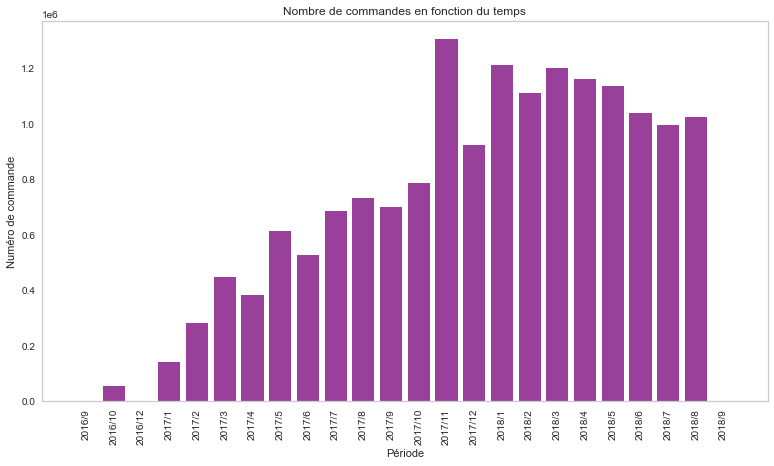

In [26]:
(fig, ax) = plt.subplots(figsize=(13, 7))
plt.title("Nombre de commandes en fonction du temps")
ax = plt.bar(range(0,time["period"].nunique()), time["Number of order"].values, color="#99419a")
plt.xticks(range(0,time["period"].nunique()),time["period"].unique(),rotation=90)
plt.xlabel("Période")
plt.ylabel("Numéro de commande")
plt.grid()

### 2.5. Barplot répartition de commandes en fonction des jours

In [23]:
time = ["order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date"]

for cols in time:
    df[cols] = pd.to_datetime(df[cols], format="%Y-%m-%d", errors="ignore")

In [24]:
order_daily = df[['order_approved_at']].groupby(df['order_approved_at'].dt.dayofweek.sort_index()).count()

daily_trend_index = order_daily.rename(columns = {'order_approved_at': 'num_of_orders'})
daily_trend = daily_trend_index.reset_index()


In [22]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in range(7):
    daily_trend['order_approved_at'] = daily_trend['order_approved_at'].replace(i,days[i])
daily_trend

,order_approved_at,num_of_orders
0,Monday,2182121
1,Tuesday,3140201
2,Wednesday,2562563
3,Thursday,2553165
4,Friday,2489404
5,Saturday,2019184
6,Sunday,1514987


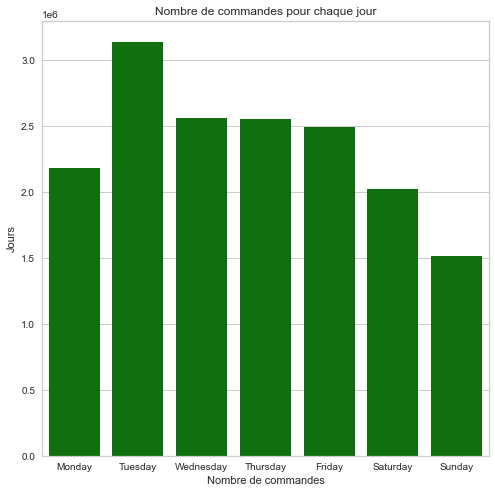

In [31]:
fig = plt.figure(figsize=(8,8))
sns.barplot(x='order_approved_at', y='num_of_orders', data=daily_trend, color = 'green')
plt.xlabel('Nombre de commandes')
plt.ylabel('Jours')
plt.title('Nombre de commandes pour chaque jour')
plt.show()

### 2.6. Barplot répartition des moyens de paiements


Text(0, 0.5, 'Nombre de paiement')

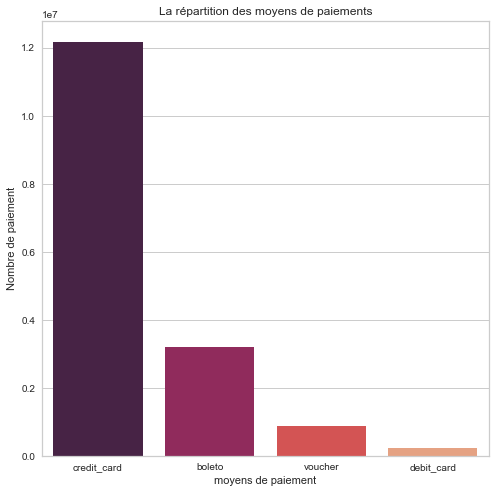

In [32]:
fig = plt.figure(figsize=(8,8))
nombre_paiment = df['payment_type'].value_counts()
top_paiement = nombre_paiment.sort_values(ascending=False)
sns.barplot(x=top_paiement.index, y=nombre_paiment, palette="rocket")
plt.title('La répartition des moyens de paiements')
plt.xlabel('moyens de paiement')
plt.ylabel('Nombre de paiement')

### 2.7. Barplot répartition des status de commande


Text(0, 0.5, 'Nombre des status de commande')

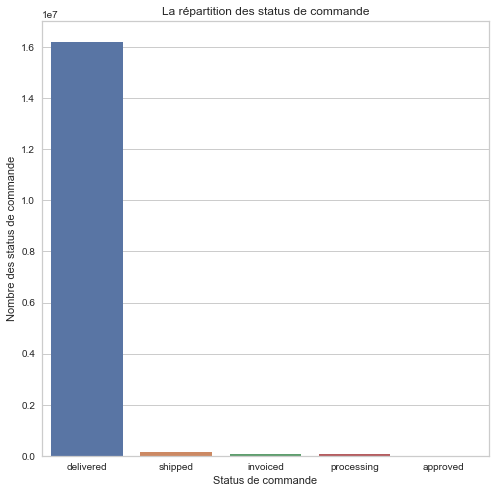

In [33]:
fig = plt.figure(figsize=(8,8))
nombre_status = df['order_status'].value_counts()
top_status = nombre_status.sort_values(ascending=False)
sns.barplot(x=top_status.index, y=nombre_status)
plt.title('La répartition des status de commande')
plt.xlabel('Status de commande')
plt.ylabel('Nombre des status de commande')

### 2.8. Histogramme nombre de paiements

In [34]:
df['payment_sequential'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  7.,  6.,  9., 11., 10.,  8., 12., 17.,
       13., 16., 19., 21., 18., 15., 20., 14., 26., 25., 24., 22., 23.,
       27., 29., 28.])

<AxesSubplot:xlabel='payment_sequential', ylabel='Density'>

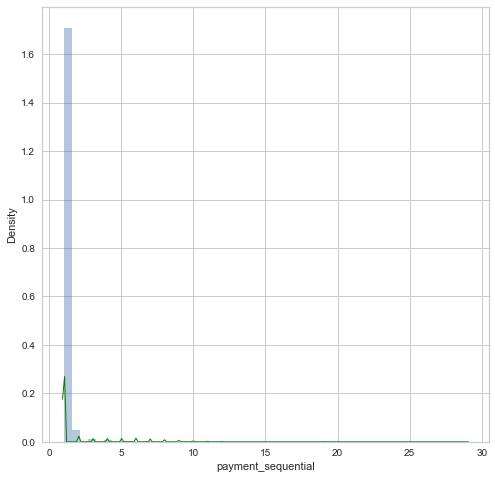

In [35]:
fig = plt.figure(figsize=(8,8))
sns.distplot(df["payment_sequential"], kde=True, kde_kws={"color": "green", "alpha": 1, "linewidth": 1})



### 2.9. Histogramme montant des commandes

<AxesSubplot:xlabel='payment_value', ylabel='Density'>

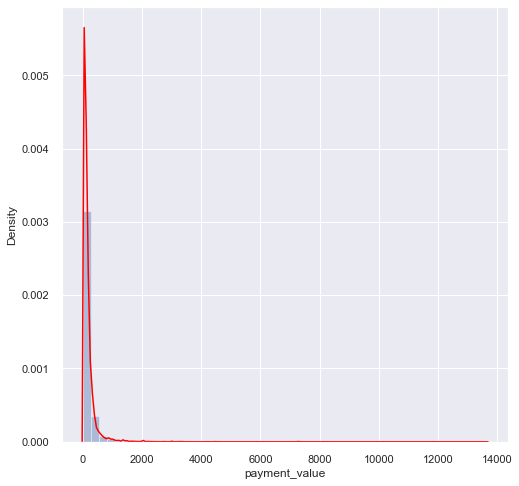

In [36]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(8,8))
sns.distplot(df["payment_value"],kde=True, kde_kws={"color": "red"})

## Conclusion de partie exploration

- Le nombre de ventes a considérablement augmenté en 2017
- En novembre 2017 les ventes ont augmenté mais en décembre 2017 et juin 2018, les ventes ont chuté
- Les clients passent le plus de commandes le mardi, tandis que le dimanche est le moins préféré
- La carte de crédit est le type de paiement le plus préférable, tandis que l'utilisation de la carte de débit est la plus faible (seulement 1 % sur plus de 100 000 commandes)
- La plupart des commandes est livré
- Les clients ont payé dans un coup et le nombre de paiment est plus 1 fois
- Les commandes commendé coutent moins 2000

## 3. Création d'une segmentation RFM(Recency, Frequency, MonetaryValue)
La segmentation RFM se base sur des habitudes de consommations comme la date du dernier achat (Recency), la fréquence d'achat (Frequency) et la valeur moyenne/la somme moyenne dépensée lors d'une commande (MonetaryValue).

### 3.1.Création des variables RFM

In [25]:
# Transformation timestamps into datetime
import datetime

time = ["order_purchase_timestamp", "order_approved_at",
        "order_delivered_carrier_date", "order_delivered_customer_date",
        "order_estimated_delivery_date"]

for cols in time:
    df[cols] = pd.to_datetime(df[cols], format="%Y-%m-%d", errors="ignore")

In [26]:
snapshot_date = max(df.order_purchase_timestamp) + datetime.timedelta(days=1)

In [27]:
# Creation of RFM segmentation
rfm_custom = df.groupby("customer_unique_id").agg({
    "order_purchase_timestamp" : lambda x: (snapshot_date - x.max()).days,
    "order_id" : 'count',
    "payment_value" : "mean"
})
rfm_custom.columns = ["Recency", "Frequency", "MonetaryValue"]
data_rfm = rfm_custom.copy().reset_index()

### 3.2.Scoring des trois variables

In [28]:
# Calculation of scores with the help of quartiles
data_rfm['r_quartile'] = pd.qcut(data_rfm['Recency'], 4, ['1', '2', '3', '4'])
data_rfm['f_bins'] = pd.cut(data_rfm['Frequency'], 2, labels=['2', '1'])
data_rfm['m_quartile'] = pd.qcut(data_rfm['MonetaryValue'], 4, ['4', '3', '2', '1'])

Une fois la discrétisation des variables R, F et M réalisée, on crée un score qui correspond à la concaténation de ces trois indices.

In [29]:
# Creation of RFM Score with the concatenation of R, F & M quartile/bins
data_rfm['RFM_Score'] = data_rfm["r_quartile"].astype(str) \
                    + data_rfm["f_bins"].astype(str) \
                    + data_rfm["m_quartile"].astype(str)
data_rfm.sort_values("RFM_Score", ascending=True)

,customer_unique_id,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score
28262,4d99682572b7b5932340a0bce676c18c,87,4872,244.020000,1,1,1,111
54864,96e91c0dba30f7ff60c9acd47677c248,47,4992,1351.440000,1,1,1,111
20955,397b44d5bb99eabf54ea9c2b41ebb905,78,6783,490.867143,1,1,1,111
49011,86bfc49565a9ca52fcbf861fcc1e67a4,83,6979,152.492857,1,1,2,112
30641,5419a7c9b86a43d8140e2939cd2c2f7e,114,6072,55.575000,1,1,4,114
...,...,...,...,...,...,...,...,...
49250,876a8881e182fb3a64af97b737cfe889,502,227,39.420000,4,2,4,424
49237,876531f7c6bb88815b1ae79c3ad4719a,427,102,33.770000,4,2,4,424
49232,875e9bc9dba22c41f1931a2d55201ec1,519,55,57.720000,4,2,4,424
85270,ea715f021baf4f64753e33d7b288b72b,467,80,55.000000,4,2,4,424


### 3.3 Analyse de la segmentation RFM

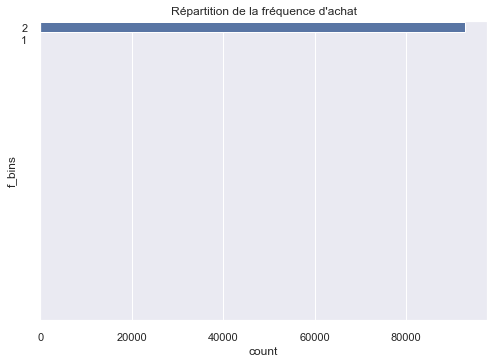

In [42]:
sns.countplot(y="f_bins", data=data_rfm)
plt.ylim(23)
plt.title("Répartition de la fréquence d'achat")
plt.show()

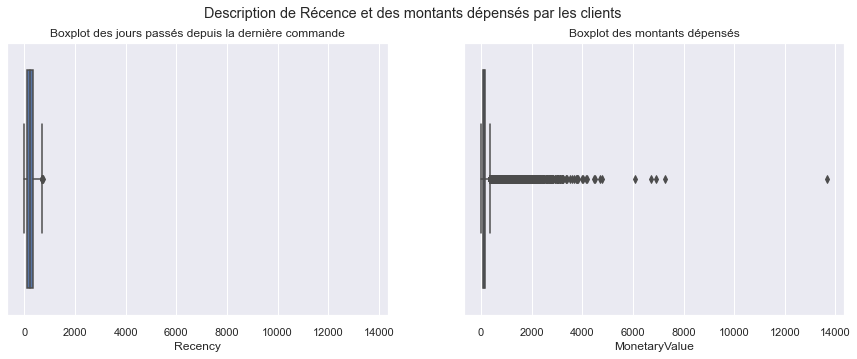

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description de Récence et des montants dépensés par les clients')

sns.boxplot(ax=axes[0], x="Recency", data=data_rfm)
axes[0].set_title("Boxplot des jours passés depuis la dernière commande")

sns.boxplot(ax=axes[1], x="MonetaryValue", data=data_rfm)
axes[1].set_title("Boxplot des montants dépensés")

plt.show()

1: la plupart des clients réalise un seul achat.
2: Les sommes dépensées atteignent un maximum de 14.000 Réaux.
3: Il est difficile de savoir s'ils reviennent régulièrement acheter donc la récence est très variable. On voit que la fréquence est inutile, il faut donc réfléchir à l'ajout de 2 nouvelles variables.


### 3.4. Nommer les segments et attribuer les individus

Les scores RFM nous donnent 533 = 125 segments. Ce qui n'est pas facile à travailler.
Je vais travailler avec 11 segments basés sur les scores R et F. Voici la description des segments :


|  Segment |  Description | 
|---   |---   |
|Champions |Acheté récemment, achetez souvent et dépensez le plus  |
|  Loyal Customers |Achetez régulièrement. Réactif aux promotions |
| Potential Loyalist  |  Clients récents avec fréquence moyenne |
|  Recent Customers |  Acheté le plus récemment, mais pas souvent |
|  Promising |  Acheteurs récents, mais qui n'ont pas dépensé beaucoup |
|  Customers Needing Attention |  Récence, fréquence et valeurs monétaires supérieures à la moyenne. Peut-être pas acheté très récemment cependant |
|  About To Sleep |  Récence et fréquence inférieures à la moyenne. Les perdront s'ils ne sont pas réactivés |
| At Risk  | acheté souvent mais il y a longtemps. Faut les ramener !  |
| Can’t Lose Them  | Utilisé pour acheter fréquemment mais n'est pas revenu depuis longtemps  |
| Hibernating  |  Le dernier achat remonte à longtemps et le nombre de commandes était faible. Peut être perdu |


In [35]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

data_rfm['rfm_segment_name'] = data_rfm['r_quartile'].astype(str) + data_rfm['f_bins'].astype(str)
data_rfm['rfm_segment_name'] = data_rfm['rfm_segment_name'].replace(segt_map, regex=True)
data_rfm.head()

,customer_unique_id,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score,label,rfm_segment_name
0,0000366f3b9a7992bf8c76cfdf3221e2,116,65,141.90,1,2,2,122,Low_value_customers,hibernating
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,144,27.19,1,2,4,124,Low_value_customers,hibernating
2,0000f46a3911fa3c0805444483337064,542,93,86.22,4,2,3,423,Low_value_customers,potential loyalists
3,0000f6ccb0745a6a4b88665a16c9f078,326,27,43.62,3,2,4,324,Low_value_customers,about to sleep
4,0004aac84e0df4da2b147fca70cf8255,293,133,196.89,3,2,1,321,Low_value_customers,about to sleep


### 3.5. Visualiser les segments de clientèle

#### 3.5.1. Méthode 1: 

In [36]:
rfm_treemap = data_rfm.groupby('rfm_segment_name').agg(customers=('customer_unique_id', 'count')).reset_index()
rfm_treemap.head()


,rfm_segment_name,customers
0,about to sleep,23207
1,hibernating,46553
2,potential loyalists,23225
3,promising,3


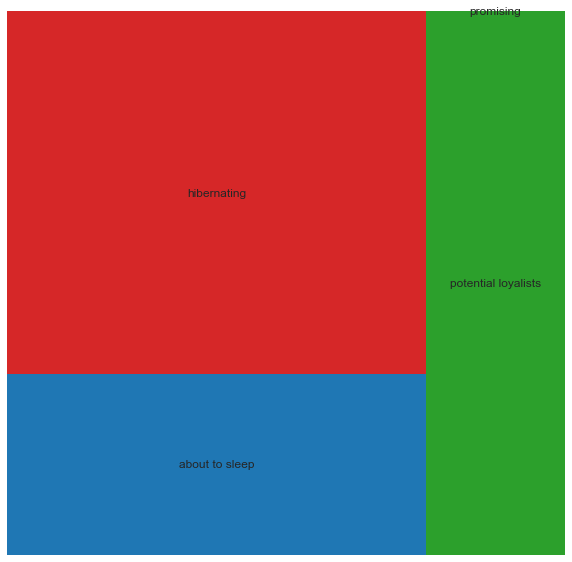

In [37]:
fig, ax = plt.subplots(1, figsize = (10,10))
squarify.plot(sizes=rfm_treemap['customers'], 
              label=rfm_treemap['rfm_segment_name'], 
              alpha=1,
              color=['tab:blue', 'tab:red', 'tab:green', 'tab:purple']
             )
plt.axis('off')
plt.show()

#### 3.5.2. Méthode 2: 

In [38]:
# Normal distribution for 'payment_value'
data_rfm['payment_value_log'] = np.log(
    data_rfm['MonetaryValue'] + 1
    )

In [39]:
# The scores will be 1, 2 or 3 for each feature of each row.1 will be a bad score. 3 will be the best possible score.

# Because of the normal distribution, we can split the distribution in 3 scores
data_rfm['payment_value_score_bis'] = pd.cut(
    data_rfm['payment_value_log'],
    bins=3,
    labels=range(1, 4)
    ).astype(int)

# Because of the special distribution, the split is arbitrary . Frequency = 1 => bad score (1) . Frequency > 2 => best score (3)
bins = [0, 1, 2, np.inf]
labels = [1, 2, 3]
data_rfm['frequency_score_bis'] = pd.cut(
    data_rfm['Frequency'],
    bins,
    labels=labels
    ).astype(int)

# Because of the normal distribution, we can split the distribution in 3 scores
data_rfm['recency_score_bis'] = 4 - pd.cut(
    data_rfm['Recency'],
    bins=3,
    labels=range(1, 4)
    ).astype(int)

# All 3 scores in one column
data_rfm['RFM_Score2'] = data_rfm['recency_score_bis'] * 100 \
                       + data_rfm['frequency_score_bis'] * 10 \
                       + data_rfm['payment_value_score_bis']


In [40]:
data_rfm['label'] = 'Low_value_customers'

data_rfm.loc[
    (data_rfm['RFM_Score2'] == 312)
    | (data_rfm['RFM_Score2'] == 313)
    | (data_rfm['RFM_Score2'] == 331),
    'label'] = 'Customers_to_retain'

data_rfm.loc[
    (data_rfm['RFM_Score2'] == 133)
    | (data_rfm['RFM_Score2'] == 123)
    | (data_rfm['RFM_Score2'] == 132)
    | (data_rfm['RFM_Score2'] == 122)
    | (data_rfm['RFM_Score2'] == 113),
    'label'] = 'Lost_customers'

data_rfm.loc[
    (data_rfm['RFM_Score2'] == 212)
    | (data_rfm['RFM_Score2'] == 213)
    | (data_rfm['RFM_Score2'] == 221)
    | (data_rfm['RFM_Score2'] == 231),
    'label'] = 'Almost_lost'

data_rfm.loc[
    (data_rfm['RFM_Score2'] == 233)
    | (data_rfm['RFM_Score2'] == 223)
    | (data_rfm['RFM_Score2'] == 232)
    | (data_rfm['RFM_Score2'] == 222),
    'label'] = 'Try_to_come_back'

data_rfm.loc[
    (data_rfm['RFM_Score2'] == 333)
    | (data_rfm['RFM_Score2'] == 323)
    | (data_rfm['RFM_Score2'] == 322)
    | (data_rfm['RFM_Score2'] == 332),
    'label'] = 'Best_customers'

result_df = pd.DataFrame({
    'R': data_rfm['Recency'],
    'F': data_rfm['Frequency'],
    'M': data_rfm['MonetaryValue'],
    'Segment': data_rfm['label']
})

result_df

,R,F,M,Segment
0,116,65,141.90,Best_customers
1,119,144,27.19,Customers_to_retain
2,542,93,86.22,Lost_customers
3,326,27,43.62,Almost_lost
4,293,133,196.89,Try_to_come_back
...,...,...,...,...
92983,452,24,2067.42,Try_to_come_back
92984,267,72,84.58,Try_to_come_back
92985,573,55,112.46,Lost_customers
92986,124,40,133.69,Best_customers


<AxesSubplot:>

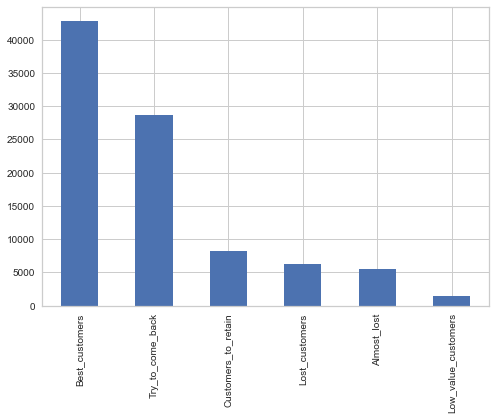

In [41]:
result_df['Segment'].value_counts().plot.bar()

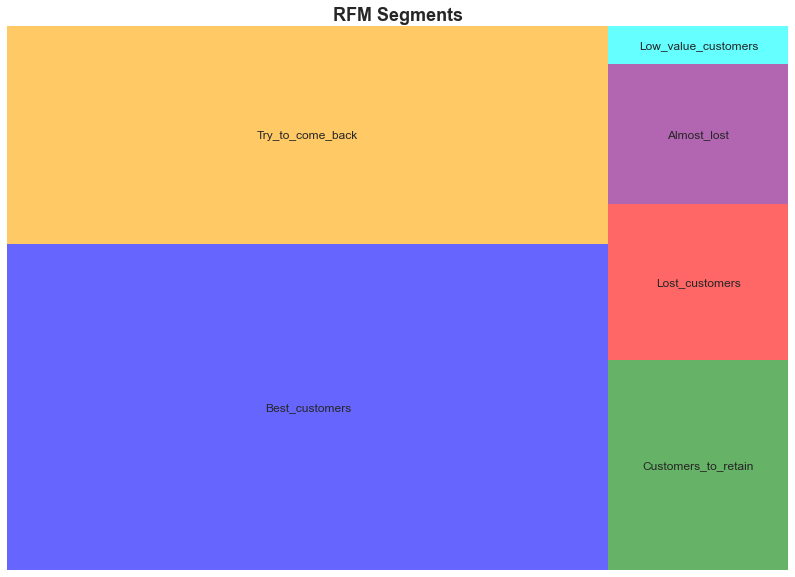

In [42]:

sizes_ = result_df['Segment'].value_counts()
label_ = sizes_.index

cmap = mpl.cm.coolwarm
mini = min(sizes_)
maxi = max(sizes_)
norm = mpl.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in sizes_]

fig = plt.gcf()
ax = fig.add_subplot()

fig.set_size_inches(14, 10)

squarify.plot(
    sizes=sizes_,
    label=label_,
    alpha=0.6,
    color=[
        'blue', 'orange', 'green', 'red', 'purple', 'cyan'
        ]
    )

plt.title('RFM Segments', fontsize=18, fontweight='bold')
plt.axis('off')

plt.show()

### 3.6. Ajouter les nouveaux indicateurs
On va créer de nouvelles variables que l'on va ajouter pour pouvoir obtenir une segmentation plus fine.
1. on va ajouter le nombre de jours entre la commande (order_approved_at) et la réception de cette dernière
2. le nombre de jours entre la date de commande livré et la date d'estimation



In [43]:
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'geolocation_lat', 'geolocation_lng',
       'order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_id', 'review_score', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name_english', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

on va calculer le nombre de jours entre la commande et la réception réel et estimé

In [30]:
df["days_before_delivered"] = df["order_delivered_customer_date"] - df["order_approved_at"]

df["days_before_delivered_estimation"] = df["order_estimated_delivery_date"] - df["order_approved_at"]

cols_var = ["days_before_delivered", "days_before_delivered_estimation"]

for cols in cols_var:
    df[cols] = df[cols].dt.days


In [45]:
percent_missing = df.isnull().sum()
percent_missing

customer_id                              0
customer_unique_id                       0
customer_zip_code_prefix                 0
customer_city                            0
customer_state                           0
geolocation_lat                        353
geolocation_lng                        353
order_id                                 0
order_status                             0
order_purchase_timestamp                 0
order_approved_at                     2721
order_delivered_carrier_date        109813
order_delivered_customer_date       252818
order_estimated_delivery_date            0
review_id                                0
review_score                             0
review_creation_date                     0
review_answer_timestamp                  0
payment_sequential                       0
payment_type                             0
payment_installments                     0
payment_value                            0
order_item_id                            0
product_id 

In [ ]:
# Supprimer les lignes sans days_before_delivered et days_before_delivered_estimation
df.dropna(subset=['days_before_delivered'], inplace=True) 

In [ ]:
# Supprimer les lignes sans days_before_delivered_estimation
df.dropna(subset=['days_before_delivered_estimation'], inplace=True) 

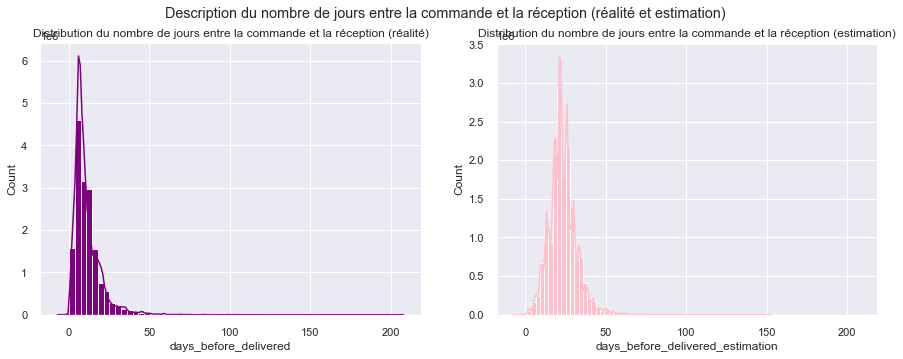

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description du nombre de jours entre la commande et la réception (réalité et estimation)')

sns.histplot(ax=axes[0], x="days_before_delivered",bins=60, color = "purple", data=df, kde=True, alpha =1, linewidth= 1 )
axes[0].set_title("Distribution du nombre de jours entre la commande et la réception (réalité)")


sns.histplot(ax=axes[1], x="days_before_delivered_estimation", bins=60, color = "pink", data=df, kde=True,  alpha =1, linewidth= 1)
axes[1].set_title("Distribution du nombre de jours entre la commande et la réception (estimation)")

plt.show()


## Préparation des données pour modeling

In [ ]:
df_filter = df.copy()
df_filter.drop_duplicates(subset="customer_unique_id", inplace=True)


In [ ]:
df_final = pd.merge(df_filter, data_rfm,
              left_on="customer_unique_id",
              right_on="customer_unique_id",
              how="right")
df_final.columns

In [ ]:
df_final.to_csv("df_clean.csv", index=False)